In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec  5 12:53:49 2021

@author: Andrey.Bezrukov
"""

import time
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.cluster import DBSCAN
import numpy as np

##################################################
####### define  functions 
##################################################

class file_Sorption:
    
    def read_file(self, path, filename):
        #print(path +'/'+ filename)        
        try:
            df = pd.read_excel(path + filename, sheet_name='DVS Data')
            if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
                self.filename = filename
                self.instrument = df.columns[0].split()[0]
                self.sample_mass = df.iloc[4, 7]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[3, 1])
                method = str(df.iloc[1, 1])
                df.columns = df.iloc[22, :]
                df = df.iloc[23:, :]
                df = df.reset_index(drop=True)
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Actual Sample Temp: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[39, :]
                df = df.iloc[40:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Mass [mg]', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Preheater Temp. [celsius]', 'Measured Preheater Temp. [celsius]']]
                df.columns = ['time', 'uptake', 'mass', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Vacuum-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[40, :]
                df = df.iloc[41:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Target Relative Pressure [%]', 'Actual Relative Pressure [%]', 'Target Preheater Temperature [°C]', 'Actual Preheater Temperature [°C]', 'Mass [mg]']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual', 'mass']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
        except Exception as e:
            print(e)
        #print(self.__dict__.keys())
        # test if import was correct
        if (list(self.__dict__.keys()) == ['filename', 'instrument', 'sample_mass', 'fluid', 'temperature', 'equilibration_interval', 'comments', 'method', 'data'])  :
            print('File {0} read succesfull'.format(filename))
            self.import_success = True
        else:
            self.import_success = False


def Create_WaterSorption_isotherm(Sorption):
    if True:
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
        
        index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
        index_tuple = sorted(index_tuple, key=lambda x: x[1])
        #print(index_tuple)
        isotherm_split = []
        prev = 'ads'
        for i, j in enumerate([i[0] for i in index_tuple]):
            if (j == 'ads')&(prev=='des'):
                isotherm_split.append(index_tuple[i][1])
            prev = j
        print(isotherm_split)
        args = [0]+isotherm_split+[Sorption.data.index.size]
        #args= args[:2]
        print(args)
        
        for start,  end in zip(args, args[1:]):
            print(start,  end)
            split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
            split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()
            
            split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
            split_index_ads = split_index_ads + [split_index_des[0]]
            
            #print(split_index_ads)
            #print(split_index_des)
            isotherm_RHtarget_ads = []
            isotherm_RHactual_ads = []
            isotherm_adsorption = []
            isotherm_adsorption_time = []
            isotherm_RHtarget_des = []
            isotherm_RHactual_des = []
            isotherm_desorption = []
            isotherm_desorption_time = []
            for i, split in enumerate(split_index_ads[:]):
                isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
                if i==0:
                    isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
                    isotherm_adsorption_time.append(0)
                else:
                    isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
                    isotherm_adsorption_time.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].time.max() - \
                                                 Sorption.data[split_index_ads[i-1]:split_index_ads[i]].time.min())
            for i, split in enumerate(split_index_des[:]):
                isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
                if i == 0:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
                    isotherm_desorption_time.append(0)
                else:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
                    isotherm_desorption_time.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].time.max() - \
                                                   Sorption.data[split_index_des[i-1]:split_index_des[i]].time.min())
    
    return isotherm_RHtarget_ads, [i for i in isotherm_adsorption], isotherm_RHtarget_des, [i for i in isotherm_desorption],  isotherm_adsorption_time, isotherm_desorption_time


In [2]:
window1 = 50
window2 = 20
text_size = 14

result = pd.DataFrame(columns=['name','isotherm','cycleNr','kinetics'], dtype=object)

datetime_stamp = datetime.now().isoformat(timespec='seconds')

#os.mkdir(datetime_stamp+'/')

import_parameters = pd.read_csv('../input_data.csv', sep=',')
import_parameters.cycleNr = import_parameters.cycleNr.astype('int32')
print(import_parameters)

analysis_time = pd.DataFrame(columns=['name','isotherm_time','kinetics_time', 'isotherm_mass', 'kinetics_mass'], dtype=object)

                                    path_kinetics  \
0   ../../../../data/water_sorption/DVS/kinetics/   
1   ../../../../data/water_sorption/DVS/kinetics/   
2   ../../../../data/water_sorption/DVS/kinetics/   
3   ../../../../data/water_sorption/DVS/kinetics/   
4   ../../../../data/water_sorption/DVS/kinetics/   
5   ../../../../data/water_sorption/DVS/kinetics/   
6   ../../../../data/water_sorption/DVS/kinetics/   
7   ../../../../data/water_sorption/DVS/kinetics/   
8   ../../../../data/water_sorption/DVS/kinetics/   
9   ../../../../data/water_sorption/DVS/kinetics/   
10  ../../../../data/water_sorption/DVS/kinetics/   
11  ../../../../data/water_sorption/DVS/kinetics/   
12  ../../../../data/water_sorption/DVS/kinetics/   
13  ../../../../data/water_sorption/DVS/kinetics/   
14  ../../../../data/water_sorption/DVS/kinetics/   
15  ../../../../data/water_sorption/DVS/kinetics/   
16  ../../../../data/water_sorption/DVS/kinetics/   
17  ../../../../data/water_sorption/DVS/kineti

### plot Figure 

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    Syloid_kinetics_50-100um_27C_12mg-2021-07-15 1...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm          syloid_isotherm_25C-2021-03-19 23-03-21.xls
color                                                            green
name                                                       Syloid AL-1
cycleNr                                                              3
analyze                                                              Y
to_paper                                                           NaN
Name: 0, dtype: object
File Syloid_kinetics_50-100um_27C_12mg-2021-07-15 13-38-52.xls read succesfull
File syloid_isotherm_25C-2021-03-19 23-03-21.xls read succesfull
Intersection:  [3.1163357062570167, 24.08392656425627]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.318359375
0.3275390625
Fitting parameters: k:  0.327539

File Montmorillonite_kinetics_27C_TGApan-2022-10-05 16-50-39.xls read succesfull
File Montmorillonite_isotherm_27C_TGApan-2022-10-04 14-48-28.xls read succesfull
Intersection:  [2.793349900787921, 22.32946117243639]
0.3
0.155
0.22749999999999998
0.26375
0.281875
0.2728125
0.27734375
0.275078125
0.2739453125
0.27337890625
Fitting parameters: k:  0.27337890625
path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    microcrystalline_cellulose_TGApan_27C_kinetics...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    microcrystalline_cellulose_isotherm_27C_TGApan...
color                                                            green
name                                                         Cellulose
cycleNr                                                              0
analyze                                                              Y
to_paper                                                           NaN


File ROS039-SD-1-183_kinetics_8mg_50-100um-2021-06-04 18-28-36.xls read succesfull
File SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls read succesfull
Intersection:  [5.58548302002054, 21.86710354594173]
0.3
2.65
1.4749999999999999
0.8875
0.59375
0.446875
0.3734375
0.33671874999999996
0.318359375
0.3091796875
Fitting parameters: k:  0.3091796875
path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    ROS-040_SD-1-82_kinetics_9mg_27C_50-100um-2021...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    ROS-040_SD-01-082_isotherm_27C-2021-06-14 09-5...
color                                                            green
name                                                           ROS-040
cycleNr                                                              3
analyze                                                              Y
to_paper                                                           NaN
Name: 17, dtyp

File 2_MS-200512_Isotherm-2020-07-30 12-52-23.xlsx read succesfull
Intersection:  [3.31055150705015, 12.943598809883138]
0.3
0.155
0.22749999999999998
0.26375
0.281875
0.2728125
0.27734375
0.279609375
0.2807421875
0.28017578125
Fitting parameters: k:  0.28017578125
path_kinetics         ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics       LX2134_kinetics_27C-2023-02-22 13-30-52.xls
path_isotherm        ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm     LX2134_2_isotherm_25C-2022-01-13 19-26-53.xls
color                                                         green
name                                            sql-(azpy)(pdia)-Ni
cycleNr                                                           1
analyze                                                           Y
to_paper                                                        NaN
Name: 25, dtype: object
File LX2134_kinetics_27C-2023-02-22 13-30-52.xls read succesfull
File LX2134_2_isotherm_25C-2022-0

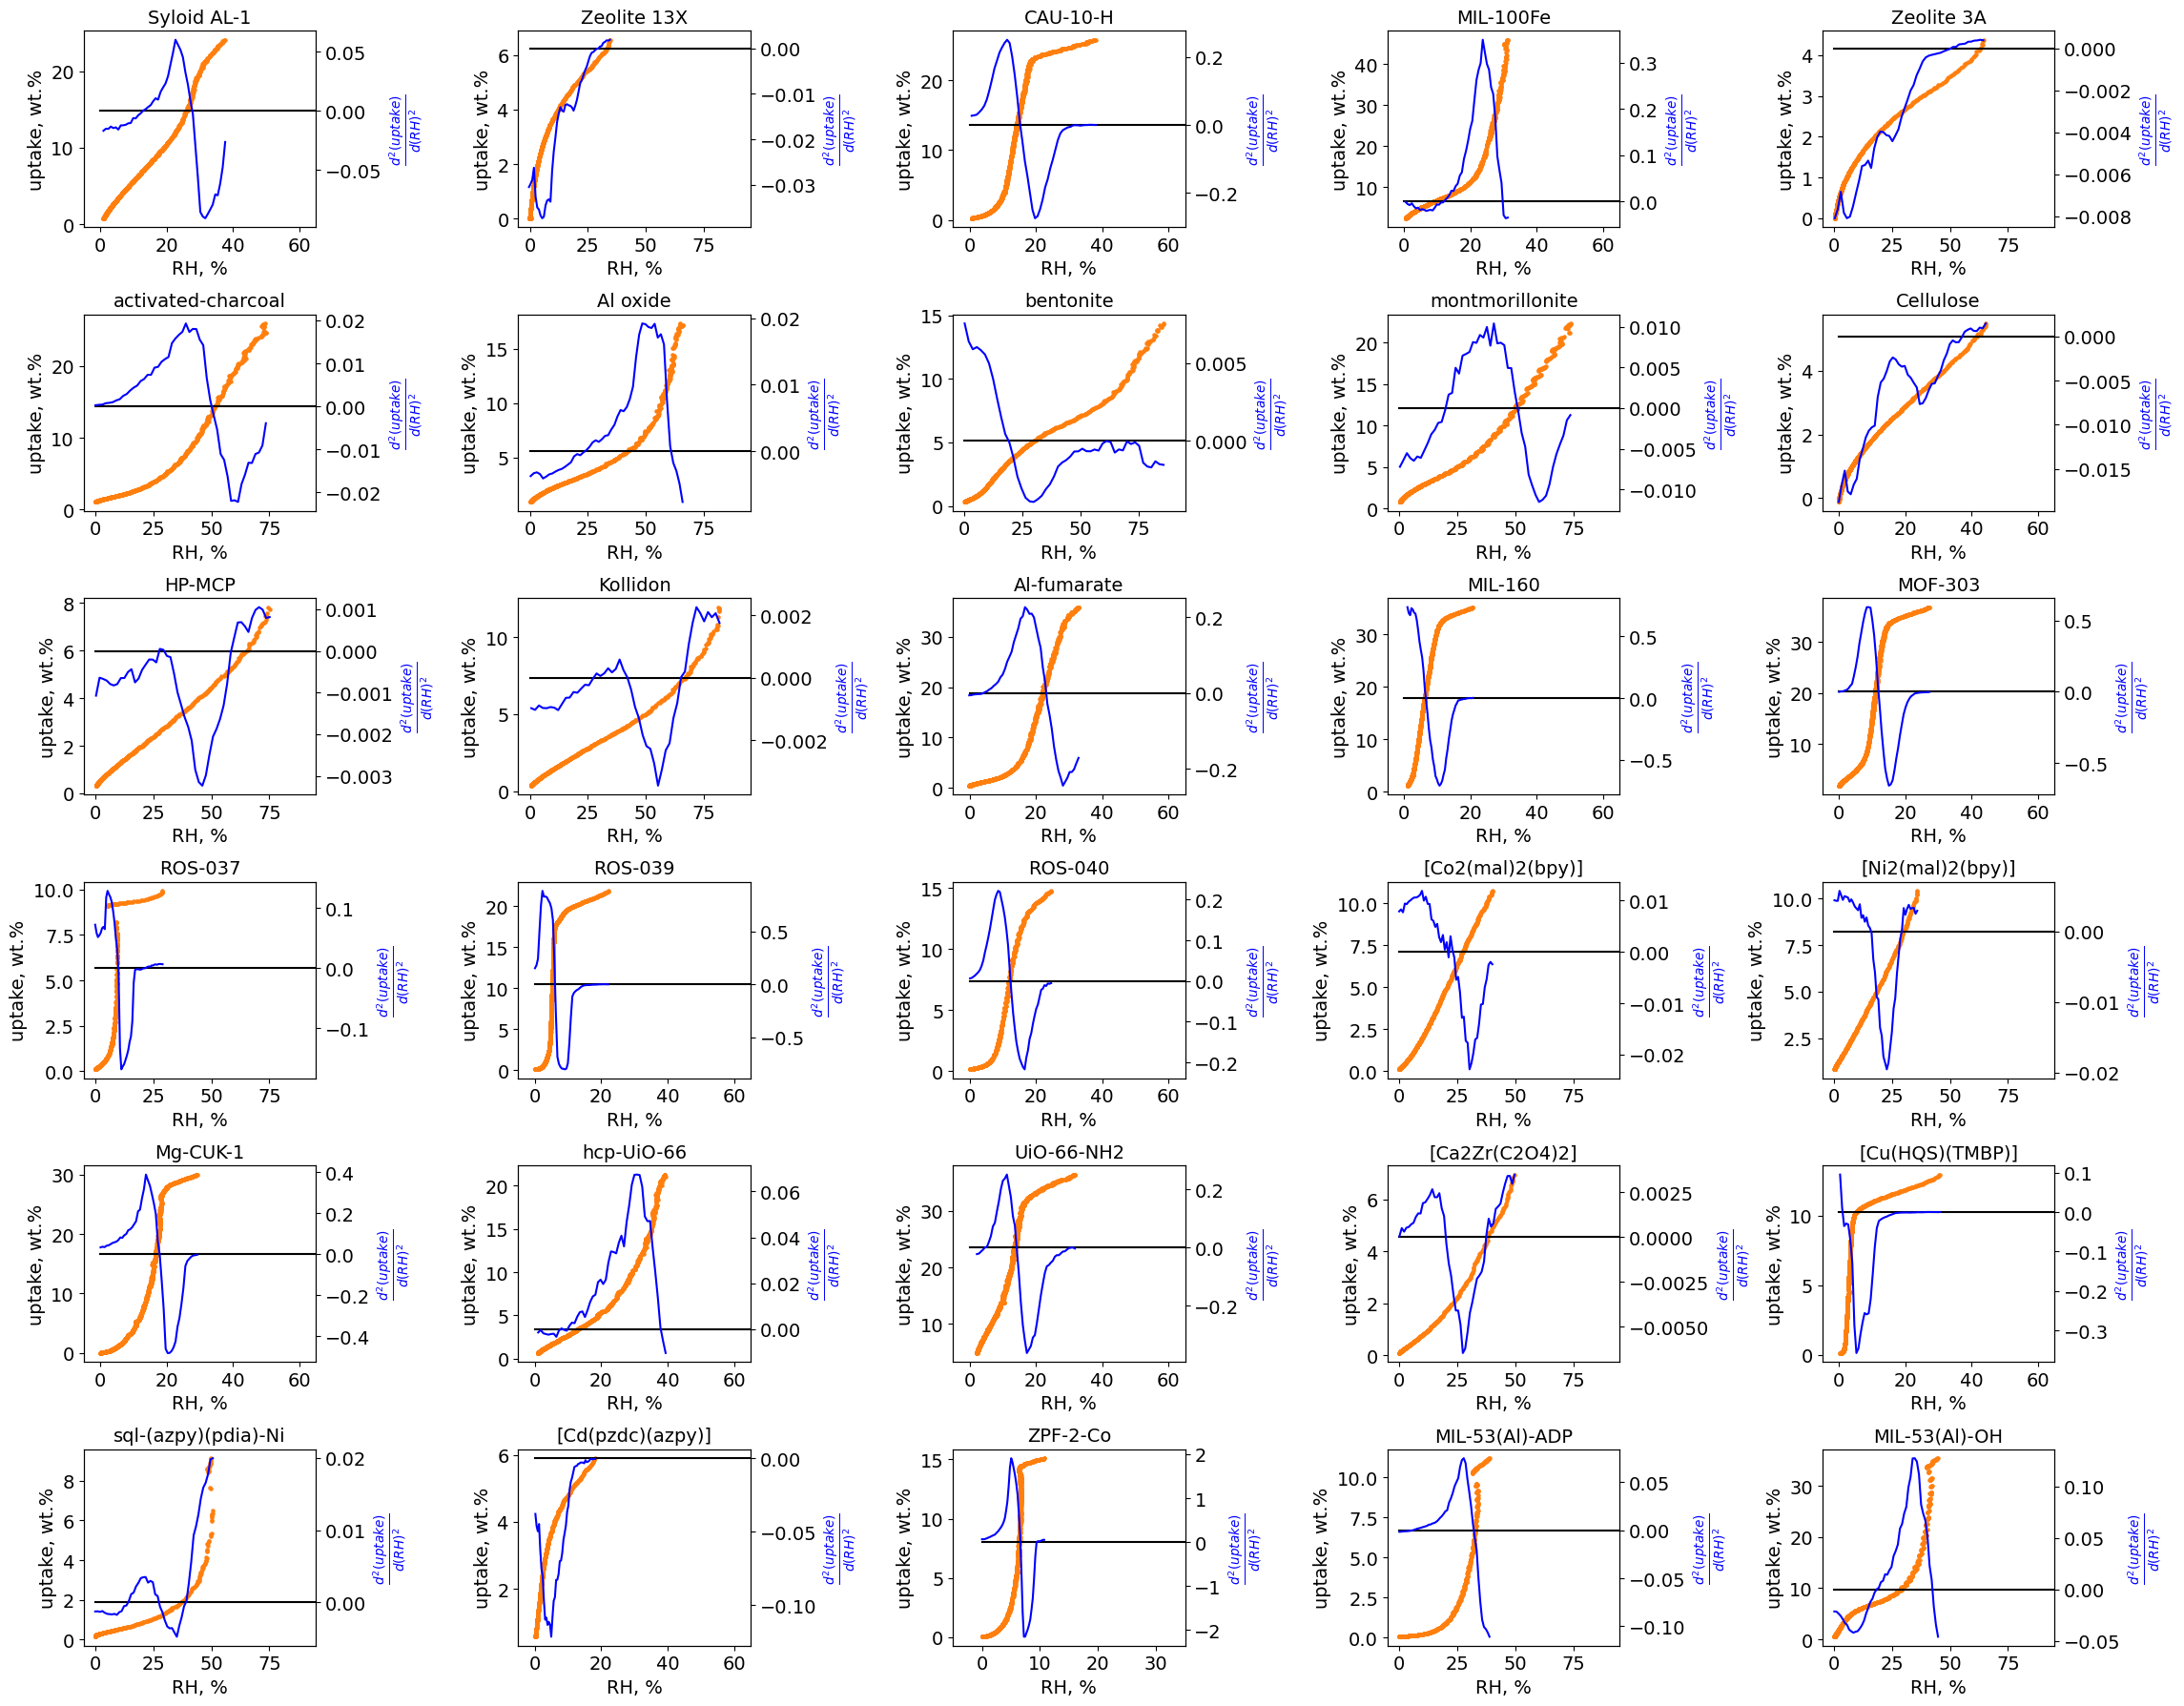

In [3]:
nrow = 6
ncol = 5
fig, ax = plt.subplots(nrow, ncol, figsize=(23, 18))

for indx in import_parameters[import_parameters.analyze=='Y'].index:
    print(import_parameters.iloc[indx, :])
    ## import kinetics
    Sorption_kinetics = file_Sorption()
    try:
        Sorption_kinetics.read_file(import_parameters.path_kinetics[indx],import_parameters.filename_kinetics[indx])
        if Sorption_kinetics.import_success:
            if Sorption_kinetics.fluid != 'water vapor':
                del Sorption_kinetics
                print('Wrong fluid: ',Sorption_kinetics.fluid)
        else:
            del Sorption_kinetics
            print(import_parameters.filename_kinetics[indx], 'failed')
            continue
    except Exception as e:
        print(e)
        print(import_parameters.filename_kinetics[indx], 'failed')
        continue
        
    ## import isotherm
    Sorption_isotherm = file_Sorption()
    try:
        Sorption_isotherm.read_file(import_parameters.path_isotherm[indx],import_parameters.filename_isotherm[indx])
        if Sorption_isotherm.import_success:
            if Sorption_isotherm.fluid != 'water vapor':
                del Sorption_isotherm
                print('Wrong fluid: ',Sorption_isotherm.fluid)
        else:
            del Sorption_isotherm
            print(import_parameters.filename_isotherm[indx], 'failed')
    except Exception as e:
        print(e)
        print(import_parameters.filename_isotherm[indx], 'failed')
        continue

    # kinetics    
        
    Sorption_kinetics.data['cycle_split'] = Sorption_kinetics.data['RH_target'].diff().fillna(0)
    Sorption_kinetics.data['cycle_split_temp'] = Sorption_kinetics.data['temp_target'].diff().fillna(0)
    split_index_ads = Sorption_kinetics.data.index[(Sorption_kinetics.data['cycle_split']>0)].to_list()
    split_index_des = Sorption_kinetics.data.index[(Sorption_kinetics.data['cycle_split']<0)].to_list()
    split_index_temp = Sorption_kinetics.data.index[(Sorption_kinetics.data['cycle_split_temp']!=0)].to_list()
    RH_max = Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['RH_target'].max()
    
        
    
    # uptake adsorption
    try:
        w_ads = pd.DataFrame({'time':Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['time'] - Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['time'].min(), 
                              'uptake':Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['uptake'],
                              'RH_actual':Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['RH_actual']
                              })
    except Exception as e:
        print(e)
        continue
        
    # first derivative adsorption
    first_derivative_dwdt_ads = pd.DataFrame({'dwdt':(w_ads['uptake'].diff()/w_ads['time'].diff()).rolling(window=window1, min_periods=1, center=True).mean(),
                                              'uptake':w_ads['uptake']
                                              })
        
    # first derivative adsorption where second derivative is negatinve
    first_derivative_dwdt_dw_ads = pd.DataFrame({'dwdt_dw':(first_derivative_dwdt_ads['dwdt'].diff()/first_derivative_dwdt_ads['uptake'].diff()).rolling(window=window2, min_periods=1, center=True).mean(),
                                                 'uptake':first_derivative_dwdt_ads['uptake']
                                                 })
    def normalize(x):
        return (x-x.min())/(x.max()-x.min())
    X = np.array([[i[0], i[1]] for i in zip(normalize(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['uptake']), normalize(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['dwdt']))  ])
    clustering_ads = DBSCAN(eps=0.1, min_samples=1).fit(X)
    #print(clustering_ads.labels_)
    
    # uptake desorption
    try:
        temp_index = [split_index_des[import_parameters.cycleNr[indx]], split_index_ads[import_parameters.cycleNr[indx]+1]]
    except: 
        temp_index = [split_index_des[import_parameters.cycleNr[indx]], Sorption_kinetics.data.index.max()]
    if [i for i in split_index_temp if (i>temp_index[0])&(i<temp_index[1])] != []:
        temp_index = [temp_index[0], min(min([i for i in split_index_temp if (i>temp_index[0])&(i<temp_index[1])]), temp_index[1])]
    try:
        w_des = pd.DataFrame({'time':Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['time'] - Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['time'].min(), 
                              'uptake':Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['uptake'], 
                              'RH_actual':Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['RH_actual'], 
                              })
    except Exception as e:
        print(e)
        continue      
    # first derivative desorption
    first_derivative_dwdt_des = pd.DataFrame({'dwdt':(w_des['uptake'].diff()/w_des['time'].diff()).rolling(window=window1, min_periods=1, center=True).mean(),
                                              'uptake':w_des['uptake']
                                              })
    
    # first derivative desorption where second derivative is negatinve
    first_derivative_dwdt_dw_des = pd.DataFrame({'dwdt_dw':(first_derivative_dwdt_des['dwdt'].diff()/first_derivative_dwdt_des['uptake'].diff()).rolling(window=window2, min_periods=1, center=True).mean(),
                                                 'uptake':first_derivative_dwdt_des['uptake']
                                                 })
    def normalize(x):
        return (x-x.min())/(x.max()-x.min())
    X = np.array([[i[0], i[1]] for i in zip(normalize(first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0]['uptake']), normalize(first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0]['dwdt']))  ])
    clustering_des = DBSCAN(eps=0.1, min_samples=1).fit(X)
    #print(clustering_des.labels_)
    
    
    ### perform RH calibration
    ### use DVS adventure k for TGA pan = 0.3
    k_adventure_TGA_min = 0.01
    k_adventure_TGA_max = 5
    k_adventure_TGA_start = 0.3
    
    try:
        
        f_des = interpolate.interp1d(first_derivative_dwdt_des['uptake'],  first_derivative_dwdt_des['dwdt'], fill_value="extrapolate")
        def interpolate_first_derivative_dwdt_dw_des(t):
            return f_des(t)
        f_ads = interpolate.interp1d(first_derivative_dwdt_ads['uptake'],  first_derivative_dwdt_ads['dwdt'], fill_value="extrapolate")
        def interpolate_first_derivative_dwdt_dw_ads(t):
            return f_ads(t)
        
        first_derivative_dwdt_dw_intersection = [first_derivative_dwdt_ads['uptake'][first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()].min(),
                                                first_derivative_dwdt_des['uptake'][first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()].max()]
        print('Intersection: ',first_derivative_dwdt_dw_intersection)
        desdata_interpolated = interpolate_first_derivative_dwdt_dw_des(first_derivative_dwdt_ads[(first_derivative_dwdt_ads.uptake>first_derivative_dwdt_dw_intersection[0])&(first_derivative_dwdt_ads.uptake<first_derivative_dwdt_dw_intersection[1])]['uptake'])
        adsdata_interpolated = interpolate_first_derivative_dwdt_dw_ads(first_derivative_dwdt_ads[(first_derivative_dwdt_ads.uptake>first_derivative_dwdt_dw_intersection[0])&(first_derivative_dwdt_ads.uptake<first_derivative_dwdt_dw_intersection[1])]['uptake'])
        RH_max = Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['RH_target'].max()
        
        for attempt in range(10):
            if attempt == 0:
                k_adventure_TGA = k_adventure_TGA_start
            else:
                k_adventure_TGA = (k_adventure_TGA_min+k_adventure_TGA_max)/2
            print(k_adventure_TGA)
            if ((-desdata_interpolated/k_adventure_TGA*Sorption_kinetics.sample_mass)<(RH_max - adsdata_interpolated/k_adventure_TGA*Sorption_kinetics.sample_mass)).all():
                k_adventure_TGA_max = k_adventure_TGA
            else: 
                k_adventure_TGA_min = k_adventure_TGA

        print('Fitting parameters: k: ',k_adventure_TGA)
        
        first_derivative_dwdt_ads['dwdt_scaled'] = RH_max - first_derivative_dwdt_ads['dwdt']/k_adventure_TGA*Sorption_kinetics.sample_mass
        first_derivative_dwdt_des['dwdt_scaled'] = -first_derivative_dwdt_des['dwdt']/k_adventure_TGA*Sorption_kinetics.sample_mass
        #frames = [first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()][['uptake', 'dwdt_scaled']],
        #          first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()][['uptake', 'dwdt_scaled']]]
        #joined_first_derivative_dwdt = pd.concat(frames, sort=True)
        #joined_first_derivative_dwdt = joined_first_derivative_dwdt.sort_values(by=['uptake'])
        #ax[0, 2].plot(joined_first_derivative_dwdt['uptake'], joined_first_derivative_dwdt['dwdt'])  
        roll_win = 200
        second_deriv_win = 10
        second_deriv_min = 1
        exp_isotherm_ads = pd.DataFrame({'RH_ads':first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()]['dwdt_scaled'],
                                 'ads':first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()]['uptake'],
                                })
        exp_isotherm_des = pd.DataFrame({'RH_des':first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()]['dwdt_scaled'],
                                 'des':first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()]['uptake'],
                                })
        exp_isotherm_ads = exp_isotherm_ads.sort_values(by=['RH_ads', 'ads']).drop_duplicates(subset=['RH_ads'], keep='last').dropna()
        exp_isotherm_des = exp_isotherm_des.sort_values(by=['RH_des', 'des']).drop_duplicates(subset=['RH_des'], keep='last').dropna()
        exp_isotherm_ads['ads_deriv1'] = exp_isotherm_ads.ads.diff()/exp_isotherm_ads.RH_ads.diff()
        exp_isotherm_des['des_deriv1'] = exp_isotherm_des.des.diff()/exp_isotherm_des.RH_des.diff()
        exp_isotherm_ads = exp_isotherm_ads[exp_isotherm_ads.ads_deriv1>0]
        exp_isotherm_des = exp_isotherm_des[exp_isotherm_des.des_deriv1>0]
        exp_isotherm_ads['ads_roll'] = exp_isotherm_ads.ads.rolling(window=roll_win, min_periods=second_deriv_min, center=True).mean()
        exp_isotherm_des['des_roll'] = exp_isotherm_des.des.rolling(window=roll_win, min_periods=second_deriv_min, center=True).mean()
        
        #ax[indx//ncol, indx%ncol].scatter(exp_isotherm_ads.RH_ads,
        #                 exp_isotherm_ads.ads,
                     #c=import_parameters.color[indx],
        #             label='adsorption',
        #             s=5)
        ax[indx//ncol, indx%ncol].scatter(exp_isotherm_des.RH_des,
                         exp_isotherm_des.des,
                     c='tab:orange',
                     label='desorption',
                     s=5)
        
        ax_twin = ax[indx//ncol, indx%ncol].twinx()
        ax_twin.plot([0, 100],[0, 0], c='black',)
        
        interpolate_monotonic_ads = interpolate.PchipInterpolator([i for i in exp_isotherm_ads.RH_ads],
                                                             [i for i in exp_isotherm_ads.ads_roll],  
                                                             )
        interpolate_monotonic_des = interpolate.PchipInterpolator([i for i in exp_isotherm_des.RH_des],
                                                             [i for i in exp_isotherm_des.des_roll],  
                                                             )
        
        interpolated_ads = pd.DataFrame({'RH_ads':np.linspace(min(exp_isotherm_ads.RH_ads), max(exp_isotherm_ads.RH_ads), 50),
                                 'ads':interpolate_monotonic_ads(np.linspace(min(exp_isotherm_ads.RH_ads), max(exp_isotherm_ads.RH_ads), 50)),
                                })
        interpolated_des = pd.DataFrame({'RH_des':np.linspace(min(exp_isotherm_des.RH_des), max(exp_isotherm_des.RH_des), 50),
                                 'des':interpolate_monotonic_des(np.linspace(min(exp_isotherm_des.RH_des), max(exp_isotherm_des.RH_des), 50)),
                                })
        #ax_twin.plot(interpolated_ads.RH_ads, 
        #         ((interpolated_ads.ads.diff()/interpolated_ads.RH_ads.diff())\
        #          .rolling(window=second_deriv_win, min_periods=second_deriv_min, center=True).mean().diff()/interpolated_ads.RH_ads.diff())\
        #             .rolling(window=second_deriv_win, min_periods=second_deriv_min, center=True).mean(),
        #            c='r')
        ax_twin.plot(interpolated_des.RH_des, 
                 ((interpolated_des.des.diff()/interpolated_des.RH_des.diff())\
                  .rolling(window=second_deriv_win, min_periods=second_deriv_min, center=True).mean().diff()/interpolated_des.RH_des.diff())\
                     .rolling(window=second_deriv_win, min_periods=second_deriv_min, center=True).mean(),
                    c='b')
        
        ax_twin.set_ylabel(r'$\frac{d^{2}(uptake)}{d(RH)^{2}}$', fontsize=text_size, c='b')
        ax_twin.tick_params(axis='y', labelsize=text_size)        
        
        ax[indx//ncol, indx%ncol].set_xlabel('RH, %', fontsize=text_size)
        ax[indx//ncol, indx%ncol].set_ylabel('uptake, wt.%', fontsize=text_size)
        ax[indx//ncol, indx%ncol].tick_params(axis='x', labelsize=text_size)
        ax[indx//ncol, indx%ncol].tick_params(axis='y', labelsize=text_size)
        ax[indx//ncol, indx%ncol].set_title(import_parameters.name[indx], fontsize=text_size)
        #ax[indx//5, indx%5].legend()    
        limx = [-5, RH_max+5]
        ax[indx//ncol, indx%ncol].set_xlim(limx)
        
    except Exception as e: 
        print(e)
        pass
    
fig.tight_layout()
plt.savefig('Figure_only_kinetics-based_differential_300dpi.png', dpi=300)
plt.show()